# Dự Đoán Giá Cổ Phiếu Sử Dụng Mô Hình Đơn Vị Định Kỳ Có Kiểm Soát (Gated Recurrent Units) 


<h1>Mục lục</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#Giới_Thiệu">Giới Thiệu</a></li>
        <li><a href="https://#Tiền_Xử_ý_Và_Lựa_Chọn_Dữ_Liệu">Tiền Xử Lý Và Lựa Chọn Dữ Liệu</a></li>
        <li><a href="https://#Phân_Tích_Dữ_Liệu_Khám_Phá_(EDA)">Phân Tích Dữ Liệu Khám Phá (EDA)</a></li>
        <li><a href="https://#Chuẩn_Bị_Cho_Dự_Đoán_Giá_Cổ_Phiếu_Đóng_Cửa_Và_Dự_Đoán_Thử">Chuẩn Bị Cho Dự Đoán Giá Cổ Phiếu Đóng Cửa Và Dự Đoán Thử</a></li>
        <li><a href="https://#Xây_Dựng_Mô_Hình_Đơn_Vị_Định_Kỳ_Có_Kiểm_Soát_Và_Đánh_Giá_Mô_Hình">Xây Dựng Mô Hình Đơn Vị Định Kỳ Có Kiểm Soát Và Đánh Giá Mô Hình</a></li>
        <li><a href="https://#So_Sánh_Mô_Hình_Dự_Đoán_Giá_Đóng_Cửa_Truyền_Thống_Và_Tiến_Hành_Dự_Đoán_Giá_Đóng_Cửa">So Sánh Mô Hình Dự Đoán Giá Đóng Cửa Truyền Thống Và Tiến Hành Dự Đoán Giá Đóng Cửa </a></li>
        <li><a href="https://#Dự_Đoán_Giá_Đóng_Cửa_30_Ngày_Tới_(Thử_Nghiệm)">Dự Đoán Giá Đóng Cửa 30 Ngày Tới (Thử_Nghiệm)</a></li>
    </ol>
</div>
<br>
<hr>


<h2> 1. Giới Thiệu </h2>

In [1]:
from IPython.display import Image
import os
!ls ../input/image1

Elonmush.jpg


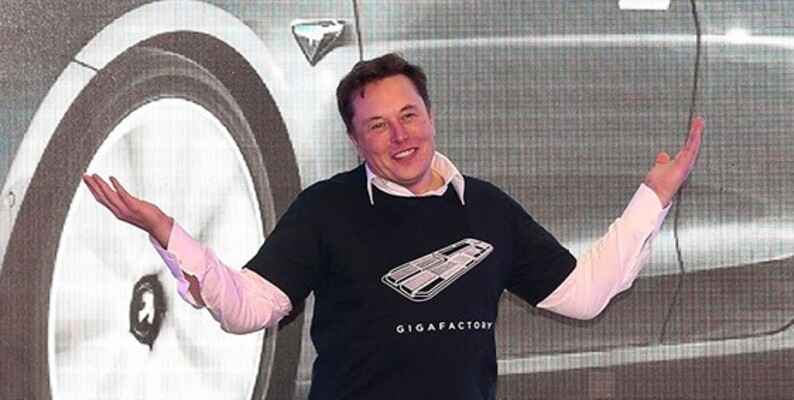

In [2]:
Image("../input/image1/Elonmush.jpg")

Trong sổ ghi chép này, chúng ta sẽ học những điều sau:
* **Kỹ Thuật Phân Tích Dữ Liệu Khám Phá**
* **Vẽ Biểu Đồ Cơ Bản Bằng Plotly**
* **Được Tìm Hiểu Về Phân Tích Chuỗi Thời Gian Bằng Mạng Thần Kinh Gated Recurrent Units (GRU)**
* **Dự Đoán Giá Cổ Phiếu Đóng Cửa 30 Ngày Tới**
    

<h2 id="2. Tiền Xử Lý Và Lựa Chọn Dữ Liệu">2. Tiền Xử Lý Và Lựa Chọn Dữ Liệu</h2>

<h3 id="Cài Đặt Thư Viện">Cài Đặt Thư Viện</h3>

In [3]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

<h3 id="Nhập tập dữ liệu">Nhập tập dữ liệu</h3>

In [4]:
Tesla_df=pd.read_csv('/kaggle/input/tesla-price-stock/TESLA_STOCK_1.csv')
Tesla_df = Tesla_df.rename(columns={'Date': 'Ngày','Open':'Giá_Mở_Cửa','High':'Giá_Cao_Nhất','Low':'Giá_Thấp_Nhất','Close':'Giá_Đóng_Cửa',
                                'Volume':'Khối_Lượng'})
Tesla_df.head()

,Ngày,Giá_Mở_Cửa,Giá_Cao_Nhất,Giá_Thấp_Nhất,Giá_Đóng_Cửa,Khối_Lượng
0,8/16/2016,45.098000,45.438000,44.681999,44.722000,11335500
1,8/17/2016,44.866001,44.966000,44.560001,44.647999,8935500
2,8/18/2016,44.764000,45.132000,44.458000,44.702000,8572500
3,8/19/2016,44.708000,45.034000,44.506001,45.000000,8297500
4,8/22/2016,44.834000,45.021999,44.535999,44.585999,10327500


In [5]:
print("Tổng Số Ngày: ",Tesla_df.shape[0])
print("Tổng Số Cột: ",Tesla_df.shape[1])

Tổng Số Ngày:  1258
Tổng Số Cột:  6


<h3 id="Kiểm tra giá trị Null và NA">Kiểm tra giá trị Null và NA</h3>

In [6]:
print("Giá trị Null:", Tesla_df.isnull().values.sum())
print("Giá Trị NA:", Tesla_df.isna().values.any())

Giá trị Null: 0
Giá Trị NA: False


<h3 id="Chuyển Đổi Trường Ngày Thành Định Dạng Ngày Giờ">Chuyển Đổi Trường Ngày Thành Định Dạng Ngày Giờ</h3>

In [7]:
# Chuyển đổi trường Ngày thành định dạng ngày giờ
Tesla_df['Ngày'] = pd.to_datetime(Tesla_df.Ngày)
Tesla_df.head()

,Ngày,Giá_Mở_Cửa,Giá_Cao_Nhất,Giá_Thấp_Nhất,Giá_Đóng_Cửa,Khối_Lượng
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500


<h2 id="3. Perform Exploratory Data Analysis(EDA)">3. Perform Exploratory Data Analysis(EDA)</h2>

In [8]:
monthvise=Tesla_df.groupby(Tesla_df['Ngày'].dt.strftime('%B'))[['Giá_Mở_Cửa','Giá_Đóng_Cửa']].mean()
new_order=['January','February','March','April','May','June','July'
          'August','September','October','November','December']
monthvise=monthvise.reindex(new_order,axis=0)
monthvise

,Giá_Mở_Cửa,Giá_Đóng_Cửa
Ngày,,
January,211.862118,212.589568
February,227.558569,227.040441
March,194.185782,193.161236
April,205.595030,205.671611
May,181.159451,180.826095
June,204.369197,204.726543
JulyAugust,NaN,NaN
September,129.064456,128.870416
October,129.469280,128.815189


In [9]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Giá_Mở_Cửa'],
    name='Giá Giao Dịch Mở Cửa',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Giá_Đóng_Cửa'],
    name='Giá Giao Dịch Đóng Cửa',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='So Sánh Theo Tháng Giữa Giá Đóng Cửa Và Mở Cửa Của Cổ Phiếu')
fig.show()

<h3 id="Giá Cổ Phiếu Thấp Nhất Và Cao Nhất Theo Tháng">Giá Cổ Phiếu Thấp Nhất Và Cao Nhất Theo Tháng </h3>

In [10]:
Tesla_df.groupby(Tesla_df['Ngày'].dt.strftime('%B'))['Giá_Thấp_Nhất'].min()
monthvise_high = Tesla_df.groupby(Tesla_df['Ngày'].dt.strftime('%B'))['Giá_Cao_Nhất'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = Tesla_df.groupby(Tesla_df['Ngày'].dt.strftime('%B'))['Giá_Thấp_Nhất'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Giá Cổ Phiếu Cao Nhất',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Giá Cổ Phiếu Thất Nhất',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title='Giá Cổ Phiếu Thấp Nhất Và Cao Nhất Theo Tháng')
fig.show()

<h3 id="So Sánh Xu Hướng Giữa Giá Mở, Giá Đóng, Giá Cao, Giá Thấp Của Cổ Phiếu">So Sánh Xu Hướng Giữa Giá Mở, Giá Đóng, Giá Cao, Giá Thấp Của Cổ Phiếu</h3>

In [11]:
names = cycle(['Giá Mở Cửa','Giá Đóng Cửa','Giá Cao Nhất','Giá Thấp Nhất'])

fig = px.line(Tesla_df, x=Tesla_df.Ngày, y=[Tesla_df['Giá_Mở_Cửa'], Tesla_df['Giá_Đóng_Cửa'], 
                                          Tesla_df['Giá_Cao_Nhất'], Tesla_df['Giá_Thấp_Nhất']],
             labels={'Ngày': 'Ngày','value':'Giá Trị Cổ Phiếu'})
fig.update_layout(title_text='Biểu Đồ Phân Tích Cổ Phiếu', font_size=15, font_color='black',legend_title_text='Thông Số Chứng Khoán')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<h2 id="4. Chuẩn Bị Cho Dự Đoán Giá Cổ Phiếu Đóng Cửa Và Dự Đoán Thử">4. Chuẩn Bị Cho Dự Đoán Giá Cổ Phiếu Đóng Cửa Và Dự Đoán Thử</h2>

<h3 id="Tạo Tệp Dữ Liệu Riêng Về Giá Đóng Cửa">Tạo Tệp Dữ Liệu Riêng Về Giá Đóng Cửa</h3>

In [12]:
Close_df=Tesla_df[['Ngày','Giá_Đóng_Cửa']]
print('Tổng Quan Về Tệp Dữ Liệu Giá Đóng Cửa:', Close_df.shape)

Tổng Quan Về Tệp Dữ Liệu Giá Đóng Cửa: (1258, 2)


<h3 id="Biểu Đồ Giá Đóng Cửa Cổ Phiếu">Biểu Đồ Giá Đóng Cửa Cổ Phiếu</h3>

In [13]:
fig = px.line(Close_df, x=Close_df.Ngày,y=Close_df.Giá_Đóng_Cửa,labels={'Ngày':'Date','Giá_Đóng_Cửa':'Close'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Biểu Đồ Giá Đóng Cửa Cổ Phiếu', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<h3 id="Chúng Tôi Chỉ Sử Dụng Dữ Liệu Trong Vòng 1 Năm Qua Để Đự Đoán">Chúng Tôi Chỉ Sử Dụng Dữ Liệu Trong Vòng 1 Năm Qua Để Đự Đoán</h3>

In [14]:
Close_df = Close_df[Close_df['Ngày'] > '2020-08-16']
Close_stock= Close_df.copy()
print("Tổng Dữ Liệu Cho Dự Đoán: ",Close_df.shape[0])

Tổng Dữ Liệu Cho Dự Đoán:  251


In [15]:
fig = px.line(Close_df, x=Close_df.Ngày, y=Close_df.Giá_Đóng_Cửa,labels={'date':'Ngày','close':'Giá_Đóng_Cửa'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Thời Gian Được Sử Dụng Để Dự Đoán Giá Đóng Cửa Cổ Phiếu', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<h3 id="Chuẩn Hóa Giá Đóng Cửa về Mức Bình Thường">Chuẩn Hóa Giá Đóng Cửa về Mức Bình Thường</h3>

In [16]:
del Close_df['Ngày']
scaler=MinMaxScaler(feature_range=(0,1))
Close_df=scaler.fit_transform(np.array(Close_df).reshape(-1,1))
print(Close_df.shape)

(251, 1)


<h3 id="Chuẩn Bị Dữ Liệu Cho Đào Tạo Và Thử Nghiệm">Chuẩn Bị Dữ Liệu Cho Đào Tạo Và Thử Nghiệm</h3>

In [17]:
training_size=int(len(Close_df)*0.60)
test_size=len(Close_df)-training_size
train_data,test_data=Close_df[0:training_size,:],Close_df[training_size:len(Close_df),:1]
print("Dữ Liệu Đào Tạo: ", train_data.shape)
print("Dữ Liệu Thử Nghiệm: ", test_data.shape)


Dữ Liệu Đào Tạo:  (150, 1)
Dữ Liệu Thử Nghiệm:  (101, 1)


<h3 id="Tiến Đổi Giá Đóng Cửa Đựa Trên Yêu Cầu Dự Báo Phân Tích Chuỗi Thời Gian">Tiến Đổi Giá Đóng Cửa Đựa Trên Yêu Cầu Dự Báo Phân Tích Chuỗi Thời Gian</h3>

In [18]:
# Chuyển Đổi Một Mảng Giá Trị Thành Ma Trận Tập Dữ Liệu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_Đào Tạo: ", X_train.shape)
print("y_Đào Tạo: ", y_train.shape)
print("X_Thử Nghiệm: ", X_test.shape)
print("y_Thử Nghiệm: ", y_test.shape)

X_Đào Tạo:  (134, 15)
y_Đào Tạo:  (134,)
X_Thử Nghiệm:  (85, 15)
y_Thử Nghiệm:  (85,)


In [20]:
# Chuẩn Hóa Lại Đầu Vào Thành [Mẫu, Bước Thời Gian, Tính Năng] Cần Thiết Cho LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_Đào Tạo: ", X_train.shape)
print("X_Thử Nghiệm: ", X_test.shape)

X_Đào Tạo:  (134, 15, 1)
X_Thử Nghiệm:  (85, 15, 1)


<h2 id="5. Xây Dựng Mô Hình Đơn Vị Định Kỳ Có Kiểm Soát (GRU) Và Đánh Giá Mô Hình">5. Xây Dựng Mô Hình Đơn Vị Định Kỳ Có Kiểm Soát (GRU) Và Đánh Giá Mô Hình</h2>

<h3 id="Xây Dựng Mô Hình Đơn Vị Định Kỳ Có Kiểm Soát (GRU)">Xây Dựng Mô Hình Đơn Vị Định Kỳ Có Kiểm Soát (GRU)</h3>

- GRU (Đơn vị lặp lại có cổng) rất giống với Bộ nhớ ngắn hạn dài (LSTM). Cũng giống như LSTM, GRU sử dụng các cổng để kiểm soát luồng thông tin. Chúng tương đối mới so với LSTM. Đây là lý do họ đưa ra một số cải tiến so với LSTM và có kiến trúc đơn giản hơn.

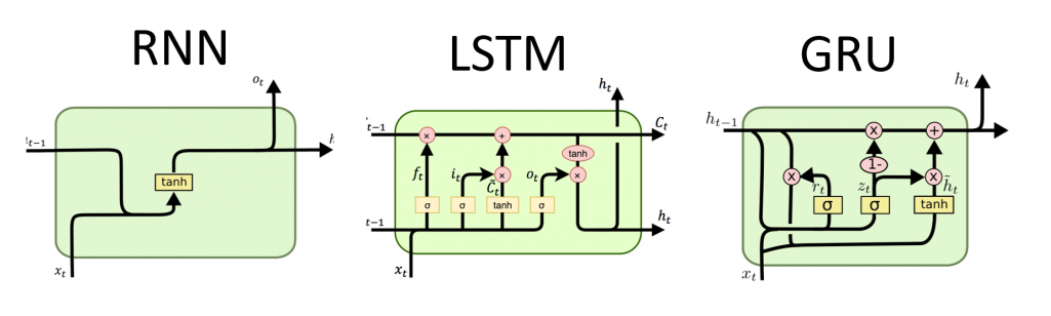

In [21]:
Image("/kaggle/input/image2/Long_shortern time memory.png")

In [22]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

2023-01-16 00:07:41.213528: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

2023-01-16 00:07:42.206974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
5/5 [==============================] - 6s 282ms/step - loss: 0.2111 - val_loss: 0.0544
Epoch 2/200
5/5 [==============================] - 0s 52ms/step - loss: 0.0386 - val_loss: 0.0150
Epoch 3/200
5/5 [==============================] - 0s 51ms/step - loss: 0.0408 - val_loss: 0.0193
Epoch 4/200
5/5 [==============================] - 0s 53ms/step - loss: 0.0262 - val_loss: 0.0033
Epoch 5/200
5/5 [==============================] - 0s 55ms/step - loss: 0.0162 - val_loss: 0.0135
Epoch 6/200
5/5 [==============================] - 0s 55ms/step - loss: 0.0249 - val_loss: 0.0072
Epoch 7/200
5/5 [==============================] - 0s 51ms/step - loss: 0.0150 - val_loss: 0.0027
Epoch 8/200
5/5 [==============================] - 0s 53ms/step - loss: 0.0143 - val_loss: 0.0059
Epoch 9/200
5/5 [==============================] - 0s 51ms/step - loss: 0.0133 - val_loss: 0.0042
Epoch 10/200
5/5 [==============================] - 0s 54ms/step - loss: 0.0130 - val_loss: 0.0025
Epoch 11/200
5/5 [

<h3 id="Vẽ biểu đồ Loss">Vẽ biểu đồ Loss</h3>

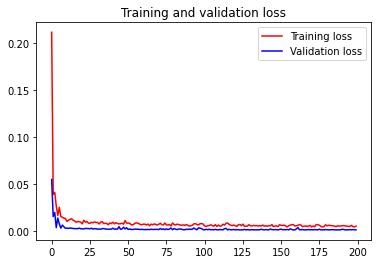

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [26]:
### Thực Hiện Dự Đoán Và Kiểm Tra Số Liệu Liệu Suất
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((134, 1), (85, 1))

<h3 id="Đánh Giá Độ Chính Xác Của Mô Hình">Đánh Giá Độ Chính Xác Của Mô Hình</h3>

In [27]:
# Chuyển Về Dạng Ban Đầu

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

<h3 id="Các Chỉ Số Đánh Giá RMSE, MSE Và MAE">Các Chỉ Số Đánh Giá RMSE, MSE Và MAE</h3>

**Root Mean Square Error :** Lỗi bình phương trung bình gốc (RMSE),**Mean Square Error :** Lỗi bình phương trung bình (MSE) và **Mean absolute Error (MAE) :** (MAE) là một cách tiêu chuẩn để đo lỗi của một mô hình trong dự đoán dữ liệu định lượng.

In [28]:
# Các Chỉ Số Đánh Giá RMSE MSE Và MAE
print("Tệp Dữ Liệu Đào Tạo RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Tệp Dữ Liệu Đào Tạo MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Tệp Dữ Liệu Đào Tạo: ", mean_absolute_error(original_ytrain,train_predict))
print("============================================================================")
print("Tệp Dữ Liệu Thử Nghiệm RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Tệp Dữ Liệu Thử Nghiệm MSE: ", mean_squared_error(original_ytest,test_predict))
print("Tệp Dữ Liệu Thử Nghiệm MAE: ", mean_absolute_error(original_ytest,test_predict))

Tệp Dữ Liệu Đào Tạo RMSE:  29.210042923969706
Tệp Dữ Liệu Đào Tạo MSE:  853.2266076201528
Tệp Dữ Liệu Đào Tạo:  22.131378179439718
Tệp Dữ Liệu Thử Nghiệm RMSE:  16.45981358937282
Tệp Dữ Liệu Thử Nghiệm MSE:  270.92546339690216
Tệp Dữ Liệu Thử Nghiệm MAE:  13.132079344577209


<h3 id="Giải Thích Điểm Hồi Quy Phương Sai">Giải Thích Điểm Hồi Quy Phương Sai</h3>

Điểm phương sai được giải thích giải thích sự phân tán sai số của một tập dữ liệu nhất định và công thức được viết như sau: Ở đây, và Var(y) lần lượt là phương sai của sai số dự đoán và giá trị thực. Điểm số gần 1,0 rất được mong muốn, cho thấy bình phương độ lệch chuẩn của sai số tốt hơn.

In [29]:
print("Dữ Liệu Đào Tạo Giải Thích Điểm Hồi Quy Phương Sai:", explained_variance_score(original_ytrain, train_predict))
print("Dữ Liệu Thử Nghiệm Giải Thích Điểm Hồi Quy Phương Sai:", explained_variance_score(original_ytest, test_predict))

Dữ Liệu Đào Tạo Giải Thích Điểm Hồi Quy Phương Sai: 0.9715652972593878
Dữ Liệu Thử Nghiệm Giải Thích Điểm Hồi Quy Phương Sai: 0.8904143932257933


<h3 id="Điểm R2 Cho Hồi Quy">Điểm R2 Cho Hồi Quy</h3>

R-squared (R2) là thước đo thống kê biểu thị tỷ lệ phương sai của một biến phụ thuộc được giải thích bởi một hoặc nhiều biến độc lập trong mô hình hồi quy.

- 1 = Tốt nhất
- 0 hoặc < 0 = tệ hơn

In [30]:
print("Điểm R2 Cho Tệp Dữ Liệu Đào Tạo:", r2_score(original_ytrain, train_predict))
print("Điểm R2 Cho Tệp Dữ Liệu Thử Nghiệm:", r2_score(original_ytest, test_predict))

Điểm R2 Cho Tệp Dữ Liệu Đào Tạo: 0.9692401395403293
Điểm R2 Cho Tệp Dữ Liệu Thử Nghiệm: 0.8794337008792437


<h3 id="Regression Loss Mean Gamma deviance regression loss:  Suy hao hồi quy Suy hao hồi quy độ lệch Gamma trung bình (MGD) ">Regression Loss Mean Gamma deviance regression loss: Suy hao hồi quy Suy hao hồi quy độ lệch Gamma trung bình (MGD)</h3>
<h3 id="Mean Poisson deviance regression loss (MPD): Suy hao hồi quy độ lệch Poisson trung bình (MPD)">Mean Poisson deviance regression loss (MPD): Suy hao hồi quy độ lệch Poisson trung bình (MPD)</h3>

In [31]:
print("MGD Cho Tệp Dữ Liệu Đào Tạo: ", mean_gamma_deviance(original_ytrain, train_predict))
print("MGD Cho Tệp Dữ Liệu Thử Nghiệm : ", mean_gamma_deviance(original_ytest, test_predict))
print("=========================================================================")
print("MGD Train Cho Tệp Dữ Liệu Đào Tạo: ", mean_poisson_deviance(original_ytrain, train_predict))
print("MPD Cho Tệp Dữ Liệu Thử Nghiệm: ", mean_poisson_deviance(original_ytest, test_predict))

MGD Cho Tệp Dữ Liệu Đào Tạo:  0.002651390984777962
MGD Cho Tệp Dữ Liệu Thử Nghiệm :  0.0006439799586756171
MGD Train Cho Tệp Dữ Liệu Đào Tạo:  1.4476954601495629
MPD Cho Tệp Dữ Liệu Thử Nghiệm:  0.41668720676969795


<h2 id="6. So Sánh Giá Đóng Cổ Phiếu Ban Đầu Và Giá Đóng Dự Đoán">6. So Sánh Giá Đóng Cổ Phiếu Ban Đầu Và Giá Đóng Dự Đoán</h2>

In [32]:
Tesla_df.head()


,Ngày,Giá_Mở_Cửa,Giá_Cao_Nhất,Giá_Thấp_Nhất,Giá_Đóng_Cửa,Khối_Lượng
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500


In [33]:
# Biều Đồ Cho Dữ Liệu Dữ Đoán

look_back=time_step
trainPredictPlot = np.empty_like(Close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Dữ Liệu Đào Tạo Dự Đoán: ", trainPredictPlot.shape)

# Biểu Đồ Cho Dữ Liệu Dữ Liệu
testPredictPlot = np.empty_like(Close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(Close_df)-1, :] = test_predict
print("Dữ Liệu Dữ Liệu: ", testPredictPlot.shape)

names = cycle(['Giá Cửa Đóng Gốc','Giá Đóng Cửa Tệp Đào Tạo Dự Đoán','Giá Đóng Cửa Tệp Thử Nghiệm Dự Đoán'])


plotdf = pd.DataFrame({'Ngày': Close_stock['Ngày'],
                       'Giá Cửa Đóng Gốc': Close_stock['Giá_Đóng_Cửa'],
                      'Giá Đóng Cửa Tệp Đào Tạo Dự Đoán': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'Giá Đóng Cửa Tệp Thử Nghiệm Dự Đoán': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Ngày'], y=[plotdf['Giá Cửa Đóng Gốc'],plotdf['Giá Đóng Cửa Tệp Đào Tạo Dự Đoán'],
                                          plotdf['Giá Đóng Cửa Tệp Thử Nghiệm Dự Đoán']],
              labels={'Giá Trị':'Giá Chứng Khoán','Ngày': 'Date'})
fig.update_layout(title_text='So Sánh Giữa Giá Đóng Cửa Ban Đầu Và Giá Đóng Cửa Dự Đoán',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Giá Chứng Khoán')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Dữ Liệu Đào Tạo Dự Đoán:  (251, 1)
Dữ Liệu Dữ Liệu:  (251, 1)


<h2 id="7. Dự Đoán Giá Đóng Cửa 30 Ngày Tới (Thử_Nghiệm)">7. Dự Đoán Giá Đóng Cửa 30 Ngày Tới (Thử_Nghiệm)</h2>

<h3 id="Dự Đoán 30 Ngày Tới">Dự Đoán 30 Ngày Tới</h3>

In [34]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Số Lượng Những Ngày Tiếp Theo Dược Dự Đoán: ", len(lst_output))

Số Lượng Những Ngày Tiếp Theo Dược Dự Đoán:  30


<h3 id="Sơ Đồ 15 Ngày Qua Của Tập Dữ Liệu Và 30 Ngày Dự Đoán Tiếp Theo">Sơ Đồ 15 Ngày Qua Của Tập Dữ Liệu Và 30 Ngày Dự Đoán Tiếp Theo</h3>

In [35]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [36]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(Close_df[len(Close_df)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Giá Đóng Cửa 15 Ngày Qua','Dự Đoán Giá Đóng Cửa 30 Ngày Tới'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Giá Cổ Phiếu','index': 'Thời Gian Theo Ngày'})
fig.update_layout(title_text='So Sánh 15 Ngày Qua Với 30 Ngày Tới',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Giá Đóng Cửa')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<h3 id="Vẽ Toàn Bộ Giá Cổ Phiếu Đóng Cửa Với Khoảng Thời Gian Dự Đoán Trong 30 Ngày Tới">Vẽ Toàn Bộ Giá Cổ Phiếu Đóng Cửa Với Khoảng Thời Gian Dự Đoán Trong 30 Ngày Tới</h3>

In [37]:
lstmdf=Close_df.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Giá Cổ Phiếu Đóng Cửa'])

fig = px.line(lstmdf,labels={'value': 'Giá Cổ Phiếu','index': 'Thời Gian Theo Ngày'})
fig.update_layout(title_text='Vẽ Toàn Bộ Giá Cổ Phiếu Đóng Cửa Với Dự Đoán',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()